In [1]:
import pandas as pd
from datetime import datetime
from lib_descriptive import plot_histograms
from lib_data import fetch_data, fetch_spot_prices, fetch_gas_prices
from lib_predictive import preprocess_data, split_data, normalize_data, reshape_data_LSTM, train_lstm_model, evaluate_model, predict_future, load_model

2025-01-26 16:06:17.814754: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1737903977.836962   51169 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1737903977.844438   51169 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-01-26 16:06:17.868967: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator



In [3]:
# reload data libaray
import importlib
import lib_data
importlib.reload(lib_data)

<module 'lib_data' from '/home/sobibence/AAU/3_semester/project/psa_tool/lib_data.py'>

In [4]:
pd.set_option('display.max_columns', None)

In [5]:
# asof = datetime.combine(datetime.now(), time.min)
asof = datetime(2024, 12, 1)
start_date = datetime(2020, 1, 1)
# read from file keys.api
API_KEY = open('keys.api').read().strip()
STATION_ID = '06030'  # Aalborg weather station
LAT, LON = 57.048, 9.9187 # Coordinates for Aalborg


Horns_rev_station = '06081'
Anholt_station = '06079'


In [6]:
historical_spot_prices = fetch_spot_prices(start_date, asof)
historical_gas_prices = fetch_gas_prices(start_date, asof)
historical_wind_data = fetch_data("https://dmigw.govcloud.dk/v2/metObs/collections/observation/items", start_date, asof, 'wind_speed', STATION_ID, API_KEY, historical=True)
historical_temp_data = fetch_data("https://dmigw.govcloud.dk/v2/metObs/collections/observation/items", start_date, asof, 'temp_dry', STATION_ID, API_KEY, historical=True)
historical_wind_data_HR = fetch_data("https://dmigw.govcloud.dk/v2/metObs/collections/observation/items", start_date, asof, 'wind_speed', Horns_rev_station, API_KEY, historical=True)
historical_wind_data_a = fetch_data("https://dmigw.govcloud.dk/v2/metObs/collections/observation/items", start_date, asof, 'wind_speed', Anholt_station, API_KEY, historical=True) 
wind_array = [historical_wind_data, historical_wind_data_HR, historical_wind_data_a]

In [7]:
historical_gas_prices

,HourDK,EEXSpotIndexEUR_MWh
0,2020-01-01 00:00:00,48.954
1,2020-01-01 01:00:00,48.954
2,2020-01-01 02:00:00,48.954
3,2020-01-01 03:00:00,48.954
4,2020-01-01 04:00:00,48.954
...,...,...
19003,2022-03-02 19:00:00,168.168
19004,2022-03-02 20:00:00,168.168
19005,2022-03-02 21:00:00,168.168
19006,2022-03-02 22:00:00,168.168


In [8]:
import lightgbm as lgb

In [9]:
df = preprocess_data(historical_spot_prices, wind_array, historical_temp_data, historical_gas_prices)

In [10]:
df.head()

,HourDK,hour,epoch,weekday,day_of_year,hour_sin,hour_cos,weekday_sin,weekday_cos,PriceEUR,wind_speed_x,wind_speed_y,wind_speed,temperature,EEXSpotIndexEUR_MWh
0,2020-01-01 00:00:00,0,1577836800000000000,2,1,0.000000,1.000000,0.974928,-0.222521,33.419998,5.850000,5.850000,5.850000,3.766667,48.954
1,2020-01-01 01:00:00,1,1577840400000000000,2,1,0.258819,0.965926,0.974928,-0.222521,31.770000,6.350000,6.350000,6.350000,4.983333,48.954
2,2020-01-01 02:00:00,2,1577844000000000000,2,1,0.500000,0.866025,0.974928,-0.222521,31.570000,6.533333,6.533333,6.533333,5.216667,48.954
3,2020-01-01 03:00:00,3,1577847600000000000,2,1,0.707107,0.707107,0.974928,-0.222521,31.280001,6.450000,6.450000,6.450000,5.116667,48.954
4,2020-01-01 04:00:00,4,1577851200000000000,2,1,0.866025,0.500000,0.974928,-0.222521,30.850000,6.450000,6.450000,6.450000,5.283333,48.954


In [10]:
import pandas as pd
import numpy as np

def prepare_features(df: pd.DataFrame) -> pd.DataFrame:
    """
    Prepares features for day-ahead price forecasting:
      - Creates day-ahead target PriceEUR_target (price shifted -24 hours).
      - Adds lagged price/weather features.
      - Adds rolling features.
      - Drops rows with NaN introduced by shifting/rolling.
    """
    df_prep = df.copy()

    # 1) Create day-ahead target
    # Shift price up by 24 hours so each row tries to predict next day's price.
    df_prep['PriceEUR_target'] = df_prep['PriceEUR'].shift(-24)

    # 2) Lagged features (common: 1 hour, 24 hours, 168 hours)
    for lag in [1, 24, 168]:
        df_prep[f'PriceEUR_lag{lag}']    = df_prep['PriceEUR'].shift(lag)
        df_prep[f'wind_speed_lag{lag}']  = df_prep['wind_speed'].shift(lag)
        df_prep[f'temp_lag{lag}']        = df_prep['temperature'].shift(lag)

    # 3) Rolling features (e.g., 24h / 168h rolling means)
    for window in [24, 168]:
        df_prep[f'PriceEUR_roll{window}'] = (
            df_prep['PriceEUR'].shift(1)
            .rolling(window=window, min_periods=1)
            .mean()
        )
        df_prep[f'wind_speed_roll{window}'] = (
            df_prep['wind_speed'].shift(1)
            .rolling(window=window, min_periods=1)
            .mean()
        )
        df_prep[f'temp_roll{window}'] = (
            df_prep['temperature'].shift(1)
            .rolling(window=window, min_periods=1)
            .mean()
        )

    # 4) Drop rows with NaN
    df_prep.dropna(inplace=True)

    return df_prep


In [11]:
# prepare_features(df)
df_prepared = prepare_features(df)

In [12]:
df_prepared.head()

,HourDK,hour,epoch,weekday,day_of_year,hour_sin,hour_cos,weekday_sin,weekday_cos,PriceEUR,wind_speed_x,wind_speed_y,wind_speed,temperature,EEXSpotIndexEUR_MWh,PriceEUR_target,PriceEUR_lag1,wind_speed_lag1,temp_lag1,PriceEUR_lag24,wind_speed_lag24,temp_lag24,PriceEUR_lag168,wind_speed_lag168,temp_lag168,PriceEUR_roll24,wind_speed_roll24,temp_roll24,PriceEUR_roll168,wind_speed_roll168,temp_roll168
168,2020-01-08 00:00:00,0,1578441600000000000,2,8,0.000000,1.000000,0.974928,-0.222521,18.950001,12.650000,12.650000,12.650000,7.900000,49.573999,25.209999,24.209999,13.566667,7.850000,28.280001,6.950000,5.016667,33.419998,5.850000,3.766667,33.497917,7.003472,6.171528,28.522917,7.283631,5.347718
169,2020-01-08 01:00:00,1,1578445200000000000,2,8,0.258819,0.965926,0.974928,-0.222521,4.960000,11.466667,11.466667,11.466667,7.833333,49.573999,25.340000,18.950001,12.650000,7.900000,28.340000,6.783333,4.816667,31.770000,6.350000,4.983333,33.109167,7.240972,6.291667,28.436786,7.324107,5.372321
170,2020-01-08 02:00:00,2,1578448800000000000,2,8,0.500000,0.866025,0.974928,-0.222521,0.100000,12.183333,12.183333,12.183333,8.516667,49.573999,27.740000,4.960000,11.466667,7.833333,28.469999,6.950000,4.866667,31.570000,6.533333,5.216667,32.135000,7.436111,6.417361,28.277202,7.354563,5.389286
171,2020-01-08 03:00:00,3,1578452400000000000,2,8,0.707107,0.707107,0.974928,-0.222521,0.110000,12.250000,12.250000,12.250000,8.983333,49.573999,32.110001,0.100000,12.183333,8.516667,28.110001,6.016667,4.950000,31.280001,6.450000,5.116667,30.952917,7.654167,6.569444,28.089881,7.388194,5.408929
172,2020-01-08 04:00:00,4,1578456000000000000,2,8,0.866025,0.500000,0.974928,-0.222521,1.750000,12.950000,12.950000,12.950000,8.800000,49.573999,29.000000,0.110000,12.250000,8.983333,28.700001,4.866667,5.200000,30.850000,6.450000,5.283333,29.786250,7.913889,6.737500,27.904345,7.422718,5.431944


In [13]:
target_col = 'PriceEUR'

In [14]:
drop_cols = ['HourDK', 'PriceEUR']  # We'll treat PriceEUR as target
feature_cols = [col for col in df_prepared.columns if col not in drop_cols]

In [17]:
X = df_prepared[feature_cols]
y = df_prepared[target_col]

In [34]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, shuffle=False, test_size=0.2
)
print("Train shape:", X_train.shape, "Test shape:", X_test.shape)


Train shape: (34040, 26) Test shape: (8511, 26)


In [15]:
import lightgbm as lgb
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

def train_lightgbm_day_ahead(df_prepared: pd.DataFrame, split_date: str):
    """
    Trains a LightGBM model for day-ahead price forecasting.
    :param df_prepared: DataFrame from prepare_features()
    :param split_date:  Date string (e.g., '2022-01-01') for time-based train/test split
    :return: fitted model, X_test, y_test
    """

    # 1) Split into training (before split_date) and testing (after split_date)
    train_data = df_prepared[df_prepared['HourDK'] < split_date]
    test_data  = df_prepared[df_prepared['HourDK'] >= split_date]

    # 2) Define features and target
    features_to_drop = [
        'HourDK',           # not used as numeric feature
        'PriceEUR',         # the *current* known price
        'PriceEUR_target'   # we’ll define it as y
    ]
    feature_cols = [c for c in df_prepared.columns if c not in features_to_drop]

    X_train = train_data[feature_cols]
    y_train = train_data['PriceEUR_target']

    X_test = test_data[feature_cols]
    y_test = test_data['PriceEUR_target']

    # 3) Create LightGBM Datasets
    dtrain = lgb.Dataset(X_train, label=y_train)
    dtest  = lgb.Dataset(X_test, label=y_test)

    # 4) Define model parameters (example starter values)
    params = {
        'objective': 'regression',
        'metric': 'rmse',
        'num_leaves': 31,
        'learning_rate': 0.05,
        'subsample': 0.8,
        'colsample_bytree': 0.8,
        'seed': 42
    }

    # 5) Train LightGBM with early stopping on the test set
    model = lgb.train(
        params,
        dtrain,
        num_boost_round=2000,
        valid_sets=[dtrain, dtest],
        valid_names=['train','test']
    )

    # 6) Evaluate on test set
    y_pred = model.predict(X_test, num_iteration=model.best_iteration)
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))

    print(f"Day-ahead forecasting: Test MAE = {mae:.2f}, Test RMSE = {rmse:.2f}")

    return model, X_test, y_test

In [17]:
def forecast_future_days(model, df_latest, forecast_horizon_days=7):
    """
    Iteratively forecasts day-ahead prices for a given horizon (e.g. 7 or 30 days).
    :param model: a LightGBM model trained to predict day-ahead prices
    :param df_latest: the most recent slice of your data, must contain the
                      necessary lag/rolling columns up to the last known real hour
    :param forecast_horizon_days: how many days to forecast
    :return: a DataFrame with the forecasted prices for each future day
    """

    # We'll create a working copy of df_latest to append new rows as we forecast.
    # Make sure df_latest has at least 168 hours of history for weekly lags, etc.
    df_future = df_latest.copy()

    # Start from the last available timestamp
    current_time = df_future['HourDK'].max()

    forecasts = []

    for day_ahead in range(1, forecast_horizon_days + 1):
        # The "target" day we are predicting (day ahead of the last known data):
        forecast_time = current_time + pd.Timedelta(days=1)

        # Build a single new row of features for 'forecast_time'
        # That means: shift the existing columns (PriceEUR_lag1, etc.)
        # We'll do so by referencing the last row in df_future.
        new_row = build_feature_row_for_forecast(df_future, forecast_time)

        # Predict the price with the model
        pred_price = model.predict(new_row)[0]

        # Save the forecast result
        forecasts.append({
            'HourDK': forecast_time,
            'forecast_price': pred_price
        })

        # Append this "predicted" data back into df_future so subsequent lags
        # can reference it. For day-ahead, we treat the predicted price as if it's the
        # "current" price for the next iteration.
        df_future = append_predicted_row(df_future, new_row, pred_price, forecast_time)

        # Update current_time
        current_time = forecast_time

    return pd.DataFrame(forecasts)

(29920, 10) (6411, 10) (6412, 10)
(29920, 1) (6411, 1) (6412, 1)


In [18]:
import pandas as pd
import numpy as np

def prepare_features_hourly(df: pd.DataFrame) -> pd.DataFrame:
    """
    Prepares features for *hour-ahead* price forecasting.
      - Creates next-hour target: PriceEUR_target = PriceEUR.shift(-1)
      - Adds lagged price, wind_speed, temperature, etc.
      - Adds rolling means (e.g., last 24h, 168h).
      - Drops rows with NaN introduced by shifting/rolling.

    Assumes the DataFrame has:
      - 'HourDK' (datetime)
      - 'PriceEUR'
      - 'wind_speed'
      - 'temperature'
      - possibly cyclical/time columns (e.g. hour_sin, weekday_sin, etc.).

    Returns: a new DataFrame with these extra columns + target.
    """
    df_prep = df.copy()

    # 1) Next-hour price as the target
    df_prep['PriceEUR_target'] = df_prep['PriceEUR'].shift(-1)

    # 2) Create lagged features (common lags: 1 hour, 24 hours, 168 hours)
    for lag in [168]:
        df_prep[f'PriceEUR_lag{lag}']    = df_prep['PriceEUR'].shift(lag)
        df_prep[f'wind_speed_lag{lag}']  = df_prep['wind_speed'].shift(lag)
        df_prep[f'temp_lag{lag}']        = df_prep['temperature'].shift(lag)

    # 3) Rolling means/stats
    for window in [24, 168]:
        df_prep[f'wind_speed_roll{window}'] = (
            df_prep['wind_speed']
            .shift(1)
            .rolling(window=window, min_periods=1)
            .mean()
        )
        df_prep[f'temp_roll{window}'] = (
            df_prep['temperature']
            .shift(1)
            .rolling(window=window, min_periods=1)
            .mean()
        )

    # 4) Drop rows with NaN from shifting/rolling
    df_prep.dropna(inplace=True)

    return df_prep

In [19]:
import lightgbm as lgb
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt

def train_lightgbm_24h(df_prepared: pd.DataFrame, split_date: str):
    """
    Trains a LightGBM model for a 24-hour (day-ahead) price forecast.
    :param df_prepared: DataFrame from prepare_features_24h()
    :param split_date:  Date string (e.g. '2023-01-01') for time-based splitting
    :return: (model, X_test, y_test)
    """

    # 1) Train/Test split by date
    train_data = df_prepared[df_prepared['HourDK'] < split_date]
    test_data  = df_prepared[df_prepared['HourDK'] >= split_date]

    # 2) Define features and target
    features_to_drop = ['HourDK', 'PriceEUR', 'PriceEUR_target']
    feature_cols = [c for c in df_prepared.columns if c not in features_to_drop]

    X_train = train_data[feature_cols]
    y_train = train_data['PriceEUR_target']
    X_test  = test_data[feature_cols]
    y_test  = test_data['PriceEUR_target']

    # 3) Create LightGBM Datasets
    dtrain = lgb.Dataset(X_train, label=y_train)
    dtest  = lgb.Dataset(X_test, label=y_test)

    # 4) Define model parameters
    params = {
        'objective': 'regression',
        'metric': 'rmse',
        'num_leaves': 31,
        'learning_rate': 0.05,
        'subsample': 0.8,
        'colsample_bytree': 0.8,
        'seed': 42
    }

    # 5) Train LightGBM with early stopping on the test set
    model = lgb.train(
        params,
        dtrain,
        num_boost_round=2000,
        valid_sets=[dtrain, dtest],
        valid_names=['train','test'],
    )

    # 6) Evaluate on the test set
    y_pred = model.predict(X_test, num_iteration=model.best_iteration)
    mae = mean_absolute_error(y_test, y_pred)
    rmse = mean_squared_error(y_test, y_pred)

    print(f"24-hour-ahead forecasting on test set after {split_date}:")
    print(f"  MAE  = {mae:.2f}")
    print(f"  RMSE = {rmse:.2f}")

    return model, X_test, y_test

In [20]:
import lightgbm as lgb
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt

def train_lightgbm_hourly(df_prepared: pd.DataFrame, split_date: str):
    """
    Trains a LightGBM model for *hour-ahead* price forecasting.
    :param df_prepared: DataFrame from prepare_features_hourly()
    :param split_date:  Date string (e.g., '2023-01-01') for time-based split
    :return: (model, X_test, y_test)
    """

    # 1) Split the data
    train_data = df_prepared[df_prepared['HourDK'] < split_date]
    test_data  = df_prepared[df_prepared['HourDK'] >= split_date]

    # 2) Define features and target
    # We'll drop columns that are not used as inputs:
    features_to_drop = ['HourDK', 'PriceEUR', 'PriceEUR_target']
    feature_cols = [c for c in df_prepared.columns if c not in features_to_drop]

    X_train = train_data[feature_cols]
    y_train = train_data['PriceEUR_target']
    X_test  = test_data[feature_cols]
    y_test  = test_data['PriceEUR_target']

    # 3) Create LightGBM datasets
    dtrain = lgb.Dataset(X_train, label=y_train)
    dtest  = lgb.Dataset(X_test, label=y_test)

    # 4) Set LightGBM params
    params = {
        'objective': 'regression',
        'metric': 'rmse',
        'num_leaves': 31,
        'learning_rate': 0.05,
        'subsample': 0.8,
        'colsample_bytree': 0.8,
        'seed': 42
    }

    # 5) Train the model, using early stopping on the test set
    model = lgb.train(
        params,
        dtrain,
        num_boost_round=2000,
        valid_sets=[dtrain, dtest],
        valid_names=['train','test']
    )

    # 6) Evaluate
    y_pred = model.predict(X_test, num_iteration=model.best_iteration)
    mae  = mean_absolute_error(y_test, y_pred)
    rmse = mean_squared_error(y_test, y_pred)
    print(f"Hour-ahead forecasting on test set after {split_date}:")
    print(f"  MAE  = {mae:.2f}")
    print(f"  RMSE = {rmse:.2f}")

    return model, X_test, y_test


In [21]:
import pandas as pd

def show_prediction_vs_actual(
    model, 
    X_test, 
    y_test, 
    n=20, 
    plot=True, 
    hours_to_plot=None
):
    """
    Generates predictions using the provided model and shows
    predicted vs. actual prices for each hour in the test set.

    Parameters
    ----------
    model : fitted regression model (e.g. LightGBM)
    X_test : pandas DataFrame
        Features for the test subset. Should share index with y_test.
        Ideally has a DateTimeIndex or at least some index that matches y_test.
    y_test : pandas Series or array
        Actual next-hour prices, aligned with X_test's index.
    n : int, optional
        Number of rows to display in the printed comparison.
    plot : bool, optional
        If True, produce a simple plot of predicted vs. actual.
    hours_to_plot : int or None, optional
        If an integer is provided, we show only the last 'hours_to_plot' hours in the plot.
        If None, we plot the entire test set.
    """

    # 1) Predict
    y_pred = model.predict(X_test)

    # 2) Create a comparison DataFrame
    df_compare = pd.DataFrame({
        'Actual': y_test,
        'Predicted': y_pred
    }, index=y_test.index)

    # 3) Print sample of first n rows
    print(f"\nSample of Actual vs. Predicted (first {n} rows):")
    print(df_compare.head(n))

    # 4) Plot
    if plot:
        df_compare_plot = df_compare.copy()

        if hours_to_plot is not None:
            # If we have a DateTimeIndex, let's slice the last N hours
            # by index position or by time. If your index is truly a DateTimeIndex,
            # you can do time-based slicing. If it's numeric, do .iloc[-hours_to_plot:].
            df_compare_plot = df_compare_plot.iloc[-hours_to_plot:]
        
        # Plot
        df_compare_plot.plot(figsize=(10, 4), marker='o')
        plt.title('Hour-Ahead: Actual vs. Predicted')
        plt.xlabel('Time Index (Hourly)')
        plt.ylabel('Price')
        plt.legend()
        plt.tight_layout()
        plt.show()


In [22]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

def show_prediction_vs_actual_24h(
    model, 
    X_test, 
    y_test, 
    n=20, 
    plot=True, 
    hours_to_plot=None
):
    """
    Generates predictions (24-hour-ahead) using the provided model
    and shows predicted vs. actual prices.

    Parameters
    ----------
    model : fitted regression model (e.g. LightGBM)
    X_test : pd.DataFrame
        Features for the test subset, ideally with a DateTimeIndex or a 'HourDK' column.
    y_test : pd.Series
        Actual day-ahead prices aligned with X_test's index.
    n : int, optional (default=20)
        Number of rows to display in the printed comparison.
    plot : bool, optional (default=True)
        If True, produce a simple plot of predicted vs. actual.
    hours_to_plot : int or None, optional
        If an integer is provided, we show only the last 'hours_to_plot' rows
        in the plot. If None, we plot the entire test set.
    """

    # 1) Predict
    y_pred = model.predict(X_test)

    # 2) DataFrame for comparison
    df_compare = pd.DataFrame({
        'Actual': y_test,
        'Predicted': y_pred
    }, index=y_test.index)

    # If your DataFrame or Series does not use datetime as index,
    # you can merge with X_test['HourDK'] or something similar:
    # df_compare['HourDK'] = X_test['HourDK']
    # df_compare.set_index('HourDK', inplace=True)

    # 3) Print sample
    print(f"\nSample of Actual vs. Predicted (first {n} rows):")
    print(df_compare.head(n))

    # 4) Plot
    if plot:
        df_compare_plot = df_compare.copy()

        if hours_to_plot is not None:
            # If hours_to_plot is an integer, slice the last 'hours_to_plot' rows
            df_compare_plot = df_compare_plot.iloc[-hours_to_plot:]

        plt.figure(figsize=(10, 4))
        plt.plot(df_compare_plot.index, df_compare_plot['Actual'], label='Actual', marker='o')
        plt.plot(df_compare_plot.index, df_compare_plot['Predicted'], label='Predicted', marker='x')
        plt.title('24-Hour-Ahead: Actual vs. Predicted')
        plt.xlabel('Time Index')
        plt.ylabel('Price')
        plt.legend()
        plt.tight_layout()

        # If you have a DatetimeIndex, format it nicely:
        ax = plt.gca()
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d %H:%M'))
        plt.gcf().autofmt_xdate()

        plt.show()


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000902 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5179
[LightGBM] [Info] Number of data points in the train set: 25814, number of used features: 26
[LightGBM] [Info] Start training from score 100.453713
Hour-ahead forecasting on test set after 2023-01-01:
  MAE  = 14.96
  RMSE = 443.44

Sample of Actual vs. Predicted (first 10 rows):
       Actual  Predicted
26304    1.38   3.769185
26305    0.09  -0.296253
26306    0.08   1.274126
26307    0.05   9.637389
26308    0.00  11.685013
26309   -0.38  14.781132
26310    0.00  16.634465
26311    0.00  25.067279
26312    0.04  24.988275
26313    0.80  17.096704


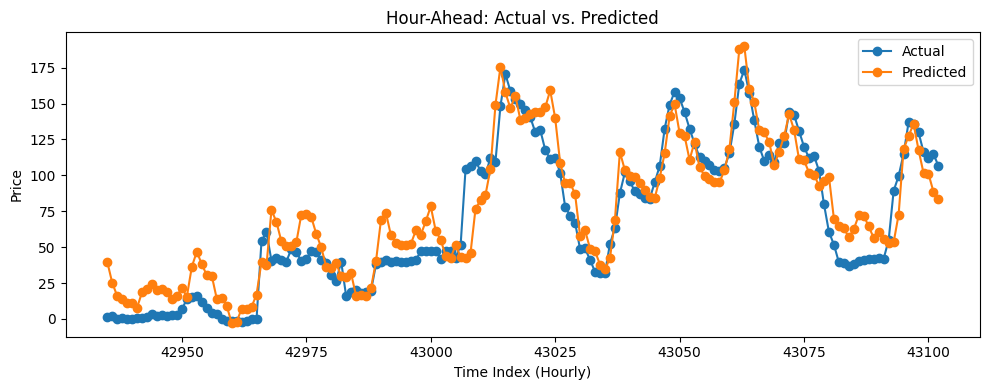

In [47]:

#    If you want HourDK as an index for convenience:
#    df_raw.set_index('HourDK', inplace=True)
# 2) Prepare features for HOUR-AHEAD

df_prep = prepare_features_hourly(df)
# 3) Choose a split date for train/test
split_date = '2023-01-01'
model, X_test, y_test = train_lightgbm_hourly(df_prep, split_date)
# 4) Show results for every hour in the test set\
show_prediction_vs_actual(
    model, X_test, y_test,
    n=10,
    plot=True,
    hours_to_plot=168  # last 168 hours (1 week) in the plot
)

In [24]:
import lightgbm as lgb
import matplotlib.pyplot as plt

def plot_feature_importance(model, feature_cols, max_num_features=20):
    """
    Plots the feature importance (split gain) for a trained LightGBM model.
    
    Parameters
    ----------
    model : lightgbm.basic.Booster
        A trained LightGBM booster (returned by `lgb.train` or `lgb.Booster`).
    feature_cols : list
        List of feature names (columns) in the same order they were passed to the model.
    max_num_features : int, optional (default=20)
        Maximum number of top features to plot.
    """

    # Use LightGBM's built-in plot function, specifying the feature names
    ax = lgb.plot_importance(
        model, 
        max_num_features=max_num_features, 
        
        importance_type='gain',    # or 'split'
        figsize=(8, 6)
    )
    
    # LightGBM’s `plot_importance` doesn’t automatically label the bars with the original feature names 
    # if we used a Dataset object, but it does show them on the y-axis.
    # If needed, you can set custom labels here. Usually, it just picks up the correct names from the model.
    
    plt.title("Feature Importance (Top {})".format(max_num_features))
    plt.tight_layout()
    plt.show()


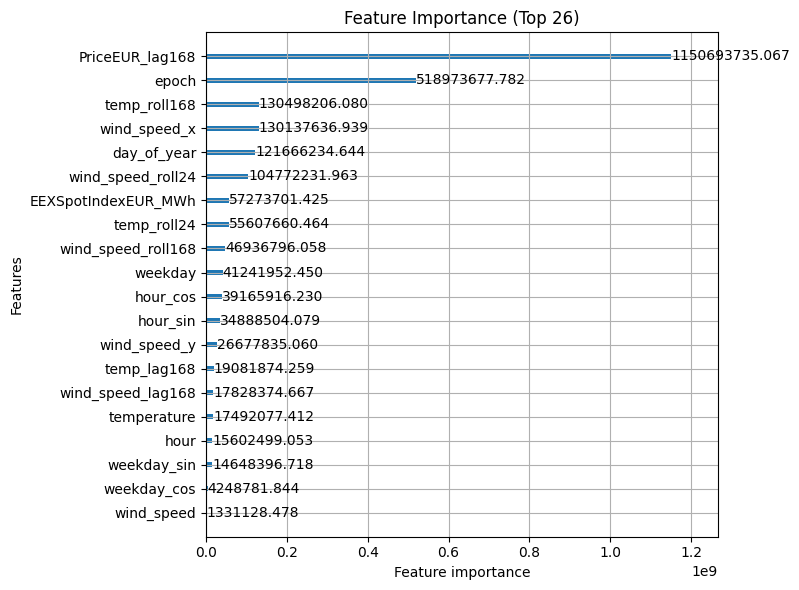

In [71]:
plot_feature_importance(model, feature_cols, max_num_features=26)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005489 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3651
[LightGBM] [Info] Number of data points in the train set: 38182, number of used features: 20
[LightGBM] [Info] Start training from score 93.728183
24-hour-ahead forecasting on test set after 2024-06-01:
  MAE  = 28.88
  RMSE = 1469.81

Sample of Actual vs. Predicted (first 10 rows):
          Actual  Predicted
38711  86.680000  73.902701
38712  77.750000  73.359762
38713  70.400002  73.066389
38714  65.110001  69.336116
38715  65.620003  67.347330
38716  65.900002  73.906092
38717  68.089996  71.857374
38718  70.750000  64.081326
38719  61.349998  46.776354
38720  47.160000  36.724443


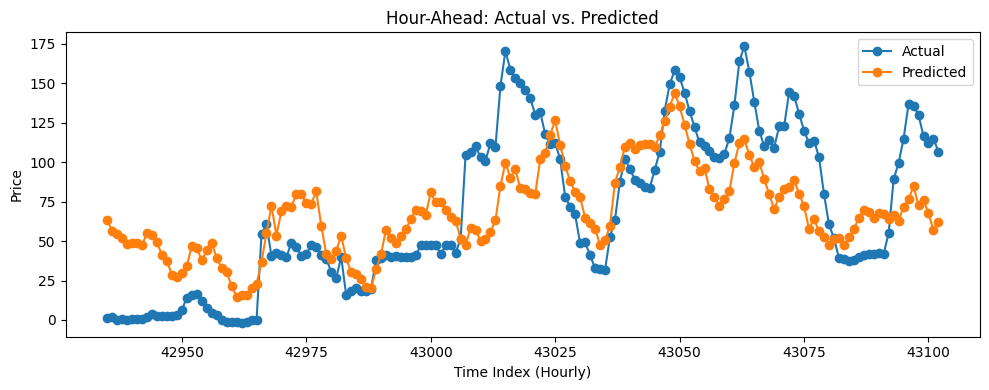

In [23]:

#    If you want HourDK as an index for convenience:
#    df_raw.set_index('HourDK', inplace=True)
# 2) Prepare features for HOUR-AHEAD

df_prep = prepare_features_hourly(df)
# 3) Train model
split_date = '2024-06-01'
model, X_test, y_test = train_lightgbm_24h(df_prep, split_date)
# 4) Compare predicted vs actual
show_prediction_vs_actual(
    model, X_test, y_test,
    n=10,
    plot=True,
    hours_to_plot=168  # last 168 hours (1 week) in the plot
)

In [31]:
# Reshape data for LSTM
X_train, X_val, X_test = reshape_data_LSTM(X_train, X_val, X_test)

print(X_train.shape, X_val.shape, X_test.shape)
print(y_train.shape, y_val.shape, y_test.shape)

# generator_training = TimeseriesGenerator(X_train, y_train, length=24, batch_size=32)
# generator_test = TimeseriesGenerator(X_test, y_test, length=24, batch_size=32)
# generator_validation = TimeseriesGenerator(X_val, y_val, length=24, batch_size=32)

(29920, 1, 10) (6411, 1, 10) (6412, 1, 10)
(29920, 1) (6411, 1) (6412, 1)


In [32]:
# Train LSTM model
model, history = train_lstm_model(X_train, y_train, X_val, y_val)

Epoch 1/20
234/234 - 13s - 56ms/step - loss: 0.0199 - val_loss: 0.0059
Epoch 2/20
234/234 - 2s - 7ms/step - loss: 0.0116 - val_loss: 0.0057
Epoch 3/20
234/234 - 2s - 9ms/step - loss: 0.0110 - val_loss: 0.0055
Epoch 4/20
234/234 - 2s - 7ms/step - loss: 0.0110 - val_loss: 0.0055
Epoch 5/20
234/234 - 2s - 7ms/step - loss: 0.0112 - val_loss: 0.0057
Epoch 6/20
234/234 - 2s - 7ms/step - loss: 0.0113 - val_loss: 0.0059
Epoch 7/20
234/234 - 2s - 7ms/step - loss: 0.0121 - val_loss: 0.0064
Epoch 8/20
234/234 - 2s - 7ms/step - loss: 0.0125 - val_loss: 0.0070
Epoch 9/20
234/234 - 2s - 7ms/step - loss: 0.0131 - val_loss: 0.0076
Epoch 10/20
234/234 - 2s - 8ms/step - loss: 0.0135 - val_loss: 0.0083
Epoch 11/20
234/234 - 2s - 8ms/step - loss: 0.0137 - val_loss: 0.0088
Epoch 12/20
234/234 - 2s - 7ms/step - loss: 0.0135 - val_loss: 0.0097
Epoch 13/20
234/234 - 2s - 7ms/step - loss: 0.0141 - val_loss: 0.0103
Epoch 14/20
234/234 - 2s - 7ms/step - loss: 0.0139 - val_loss: 0.0110
Epoch 15/20
234/234 - 2s - 

201/201 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step
Mean Absolute Error: 0.16 EUR


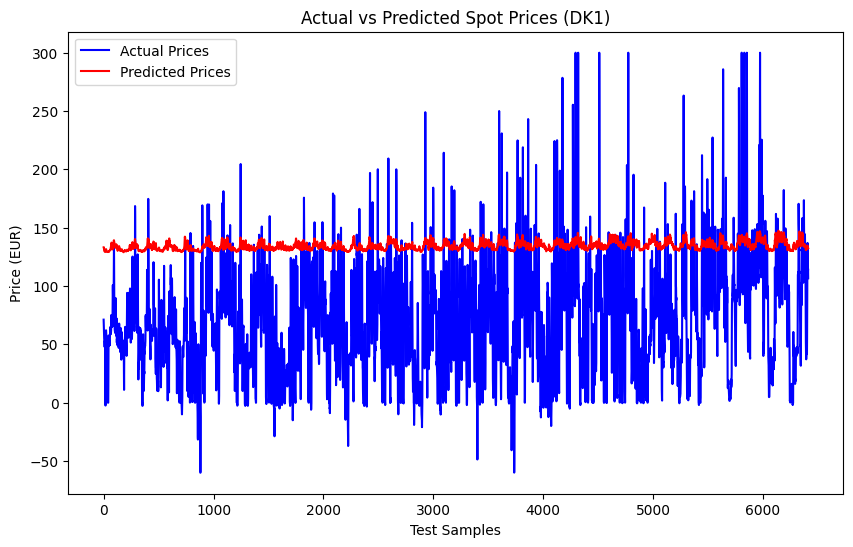

In [33]:
from lib_descriptive import plot_predictions


predictions = evaluate_model(model, X_test, y_test)
scaled_predictions = scaler_y.inverse_transform(predictions)
scaled_y_test = scaler_y.inverse_transform(y_test)
plot_predictions(scaled_y_test, scaled_predictions)

In [34]:
# Load the model for future predictions
import lib_predictive
import lib_descriptive
import lib_prescriptive
from keras.models import load_model

model = load_model('lstm_model.keras')

201/201 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


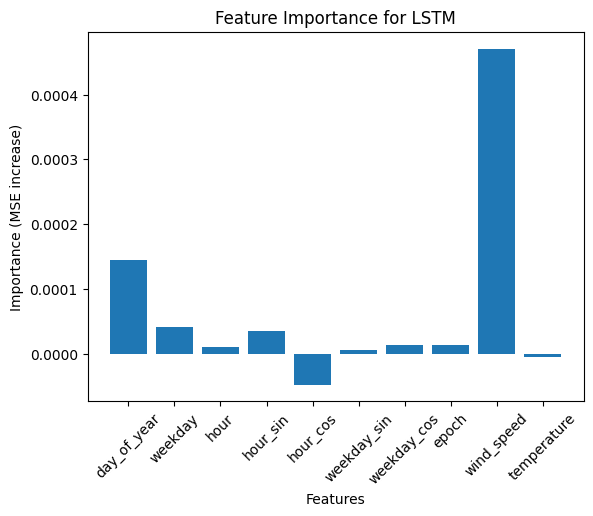

In [35]:
from sklearn.metrics import mean_squared_error
import numpy as np
import matplotlib.pyplot as plt
baseline_mse = mean_squared_error(y_test, model.predict(X_test))

def permutation_importance(model, X_test, y_test, baseline_mse):
    importances = []
    for feature in range(X_test.shape[2]):
        X_permuted = X_test.copy()
        np.random.shuffle(X_permuted[:, :, feature])  # Shuffle one feature at a time
        mse = mean_squared_error(y_test, model.predict(X_permuted))
        importances.append(mse - baseline_mse)
    return importances

# Compute feature importances
importances = permutation_importance(model, X_test, y_test, baseline_mse)

# Assuming feature names are available
feature_names = features
plt.bar(feature_names, importances)
plt.xlabel('Features')
plt.ylabel('Importance (MSE increase)')
plt.title('Feature Importance for LSTM')
plt.xticks(rotation=45)
plt.show()

6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 96ms/step


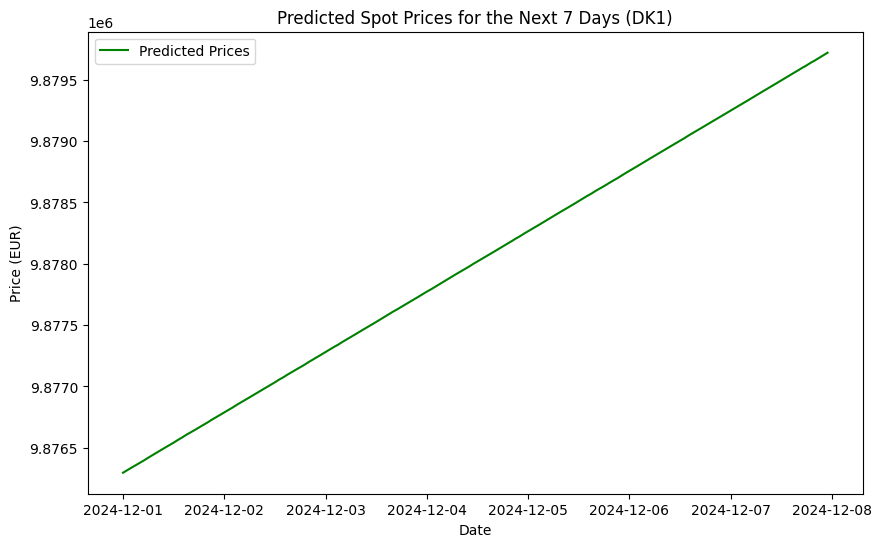

In [36]:

future_df = predict_future(model, asof)
# rescale priceEUR to original scale
future_df['PriceEUR'] = scaler_y.inverse_transform(future_df['PriceEUR'].values.reshape(-1, 1))


In [37]:
print(future_df)
print(predictions)

         PriceEUR              HourDK
0    4.246413e+09 2024-12-01 00:00:00
1    4.246422e+09 2024-12-01 01:00:00
2    4.246430e+09 2024-12-01 02:00:00
3    4.246439e+09 2024-12-01 03:00:00
4    4.246448e+09 2024-12-01 04:00:00
..            ...                 ...
163  4.247850e+09 2024-12-07 19:00:00
164  4.247858e+09 2024-12-07 20:00:00
165  4.247867e+09 2024-12-07 21:00:00
166  4.247876e+09 2024-12-07 22:00:00
167  4.247885e+09 2024-12-07 23:00:00

[168 rows x 2 columns]
[[0.6119788 ]
 [0.61102676]
 [0.6105051 ]
 ...
 [0.6097752 ]
 [0.61090684]
 [0.61031103]]


In [38]:
future_df

,PriceEUR,HourDK
0,4.246413e+09,2024-12-01 00:00:00
1,4.246422e+09,2024-12-01 01:00:00
2,4.246430e+09,2024-12-01 02:00:00
3,4.246439e+09,2024-12-01 03:00:00
4,4.246448e+09,2024-12-01 04:00:00
...,...,...
163,4.247850e+09,2024-12-07 19:00:00
164,4.247858e+09,2024-12-07 20:00:00
165,4.247867e+09,2024-12-07 21:00:00
166,4.247876e+09,2024-12-07 22:00:00
